In [190]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import matplotlib.pyplot as plt

In [191]:
adata = sc.read_h5ad("/Users/neuropromotion/Desktop/german/hw2/data.h5ad")

In [192]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [193]:
# Общее количество клеток и генов
num_cells = adata.n_obs  # Число клеток
num_genes = adata.n_vars  # Число генов

print(f"Количество клеток: {num_cells}")
print(f"Количество генов: {num_genes}")

Количество клеток: 30132
Количество генов: 59236


In [194]:
# Попробуем получить версию схемы, если она есть
schema_version = adata.uns.get("schema_version", "Схема не указана")

print(f"Версия схемы: {schema_version}")

Версия схемы: 5.2.0


In [308]:
print(adata.var.columns)

Index(['Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered',
       'feature_name', 'feature_reference', 'feature_biotype',
       'feature_length', 'feature_type', 'n_cells_by_counts', 'mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'mt', 'n_cells'],
      dtype='object')


In [311]:
print(adata.obs.columns)

Index(['roi', 'organism_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id',
       'sex_ontology_term_id', 'development_stage_ontology_term_id',
       'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial',
       'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs',
       'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id',
       'cell_type_ontology_term_id', 'tissue_ontology_term_id',
       'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease',
       'organism', 'sex', 'tissue', 'self_reported_ethnicity',
       'development_stage', 'observation_joinid', 'mean_counts',
       'n_genes_by_counts', 'total_counts', 'doublet_score', 'is_doublet',
       'n_genes'],
      dtype='object')


In [312]:
num_unique_feature_types = adata.var['feature_type'].nunique()
print(num_unique_feature_types)

19


In [316]:
adata.var['feature_type'].unique()

['protein_coding', 'lncRNA', 'transcribed_unprocessed_pseudogene', 'unprocessed_pseudogene', 'processed_pseudogene', ..., 'snoRNA', 'TR_V_pseudogene', 'IG_V_gene', 'ribozyme', 'pseudogene']
Length: 19
Categories (19, object): ['IG_V_gene', 'Mt_rRNA', 'TEC', 'TR_C_gene', ..., 'transcribed_unitary_pseudogene', 'transcribed_unprocessed_pseudogene', 'unitary_pseudogene', 'unprocessed_pseudogene']

In [196]:
# Эта функция нужна для добавления метрик контроля качества что бы потом изобразить их ниже (n_genes_by_count and total_counts)
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
# adata - наш anndata файл
# percent_top=None - процент верхних генов для которых будет применятся измерение качества (None - значит все гены будут учавствовать)
# log1p=False - к метрикам не будет применен логарифм
# inplace=True - изменения будут сразу проведены в самом файле adata, а не в копии

In [197]:
# добавляем среднее значение экспрессии по всем генам в каждой клетке. Может предоставить информацию о среднем уровне экспрессии клетки
adata.obs['mean_counts'] = adata.X.mean(axis=1)

In [198]:
mask = adata.var_names.str.startswith('MT-') # создаем бинарный массив, методом поиска префикса MT- у названия генов (мы помним что мы используем названия генов как название переменных, и все они уникальны)
print(f"Mito genes: {adata.var_names[mask].tolist()}") # печатаем че там вышло

adata.var['mt'] = mask # Добавляем информацию о том, является ли ген митохондриальным, в объект adata.var

Mito genes: []


In [199]:
# Поскольку митохондриальных генов нет, то можно закомментить код ниже
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

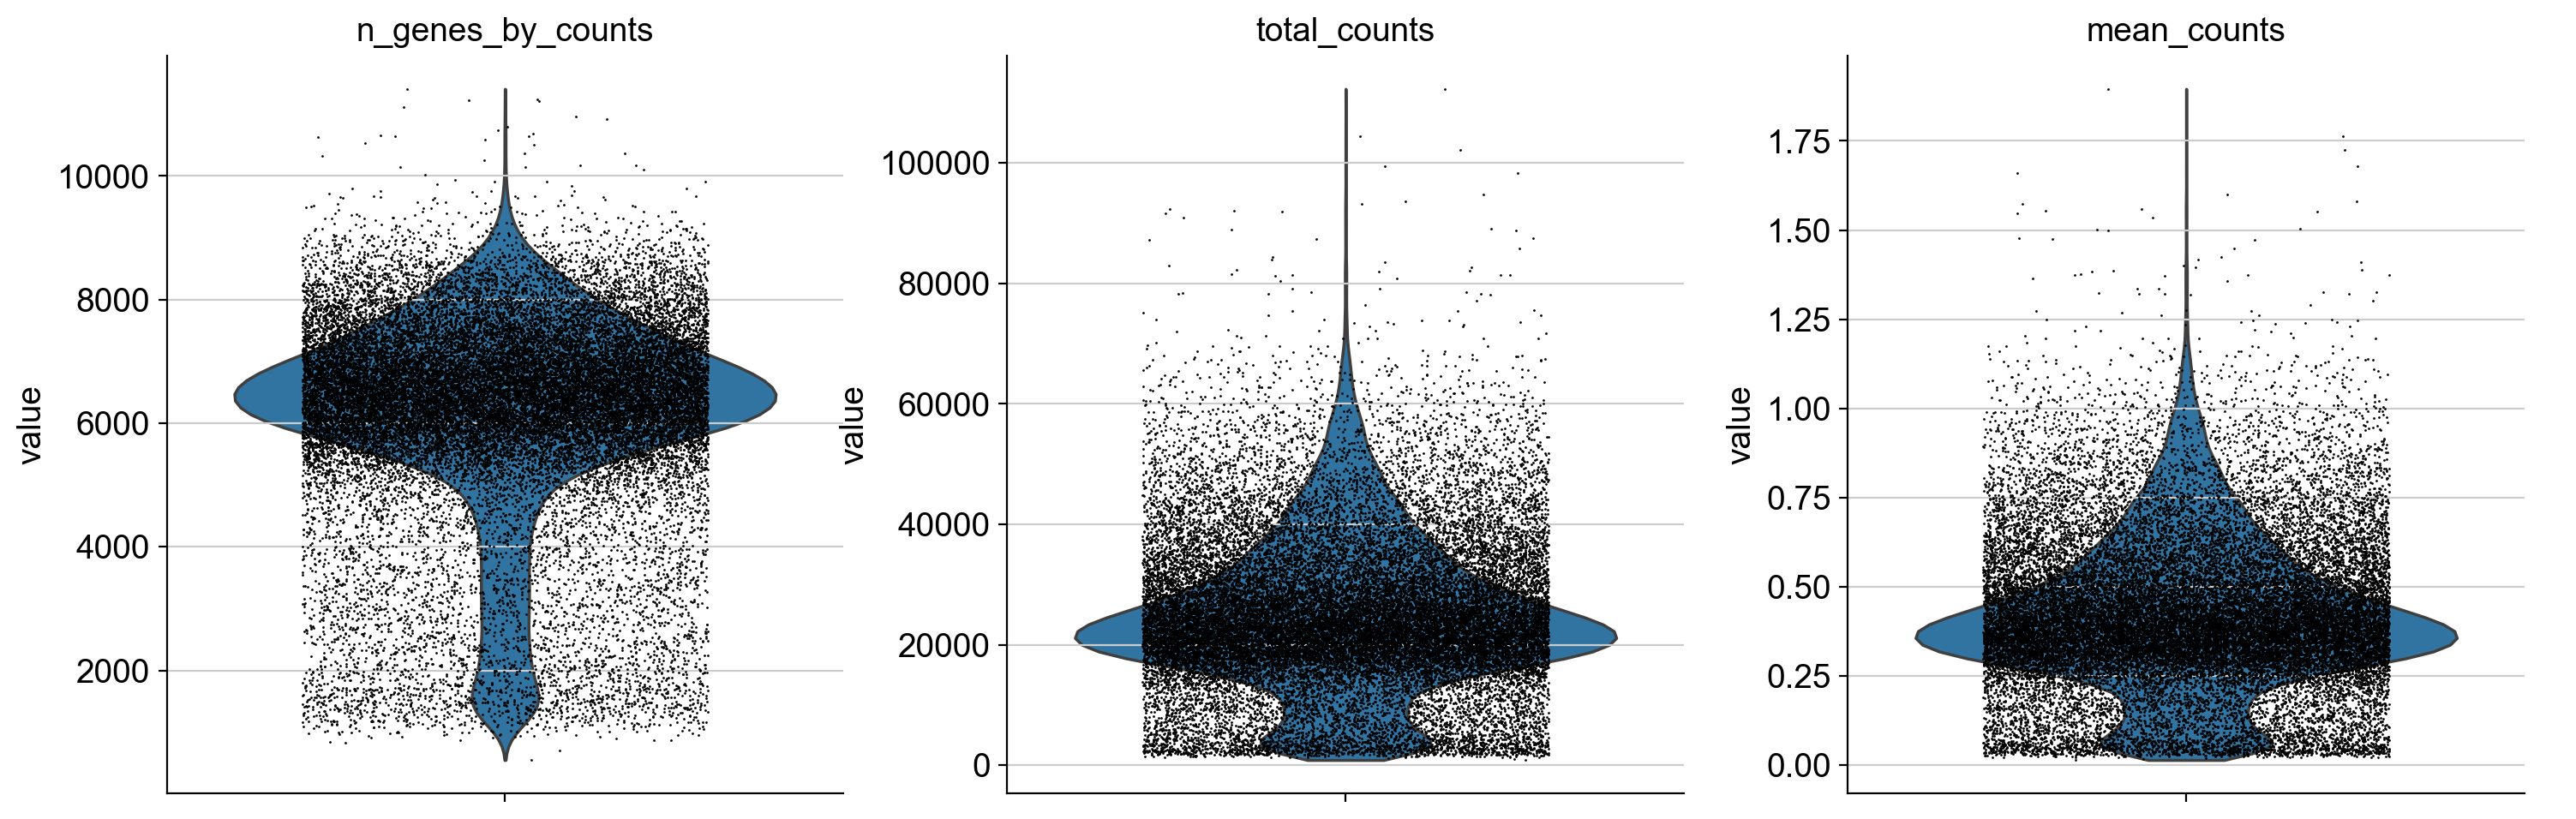

In [200]:
# sc.pl.violin - функция рисующая скрипочные (ппохожие на скрипку - violin) картинки
# adata - данные
# [['n_genes_by_counts', 'total_counts', 'mean_counts', 'pct_counts_mt'] - набор параметров которые мы будем визуализировать
# n_genes_by_count - количество генов, обнаруженных в каждой клетке на основе их экспрессии
# total_counts - общее количество обнаруженных молекул мРНК в каждой клетке
# mean_counts -  среднее значение экспрессии по всем генам в каждой клетке
# pct_counts_mt - процент генов относящихся к митохондриальных
# jitter=0.3 - этот параметр добавляет случайный шум для лучшей визуализации.
# multi_panel=True - графики для разных метрик следует размещать на нескольких панелях.
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts', 'mean_counts'],
    jitter=0.3, multi_panel=True
)

In [165]:
import scrublet as scr # удаляем дубликаты

In [201]:
# Инициализация scrublet с raw count матрицей
scrub = scr.Scrublet(adata.X)

# Определение вероятности дубликатов
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.75
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 28.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.2%
Elapsed time: 307.0 seconds


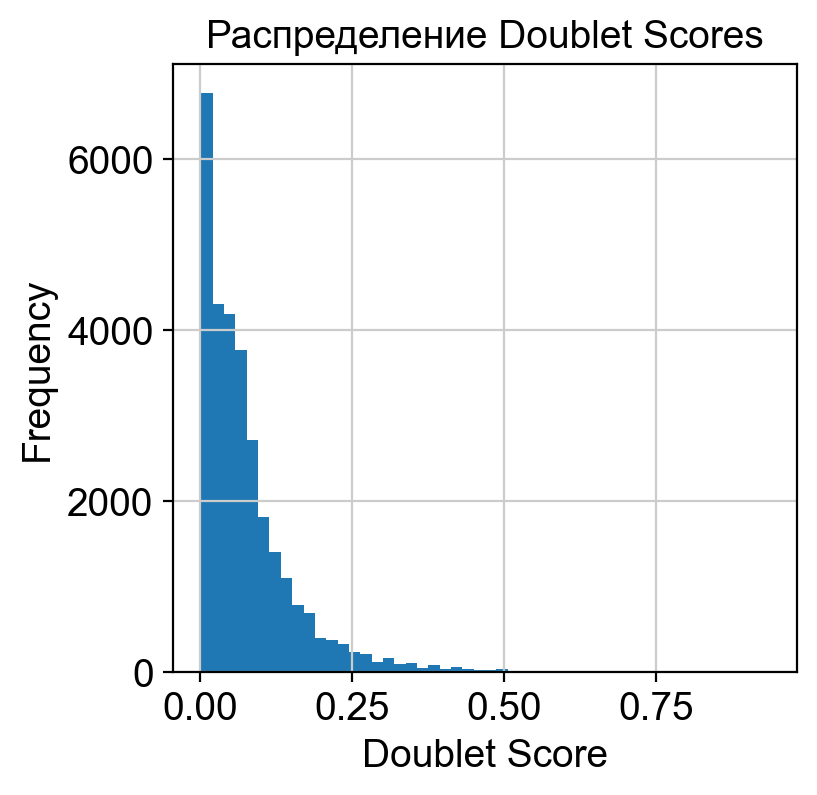

In [202]:
import matplotlib.pyplot as plt
plt.hist(doublet_scores, bins=50)
plt.xlabel("Doublet Score")
plt.ylabel("Frequency")
plt.title("Распределение Doublet Scores")
plt.show()

In [203]:
# Сохранение результатов в метаданные
adata.obs['doublet_score'] = doublet_scores
adata.obs['is_doublet'] = predicted_doublets

# Определение порога для фильтрации дубликатов (например, 0.25)
threshold = 0.25
adata = adata[adata.obs['doublet_score'] < threshold].copy()

# Итоговое количество клеток после фильтрации
print(f"Оставшееся количество клеток: {adata.n_obs}")

Оставшееся количество клеток: 28754


In [204]:
sc.pp.filter_cells(adata, min_genes=2000) # Эта функция удаляет клетки с числом обнаруженных генов меньше 2000
# Это может быть основано на предположении, что клетки с очень низким числом обнаруженных генов могут представлять собой шум или пустые капли, и их следует удалить из анализа.
sc.pp.filter_genes(adata, min_cells=200) # Эта функция удаляет гены, которые обнаружены в менее чем 100 клетках
adata

filtered out 1257 cells that have less than 2000 genes expressed
filtered out 36208 genes that are detected in less than 200 cells


AnnData object with n_obs × n_vars = 27497 × 23028
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'mean_counts', 'n_genes_by_counts', 'total_counts', 'doublet_score', 'is_doublet', 'n_genes'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_b

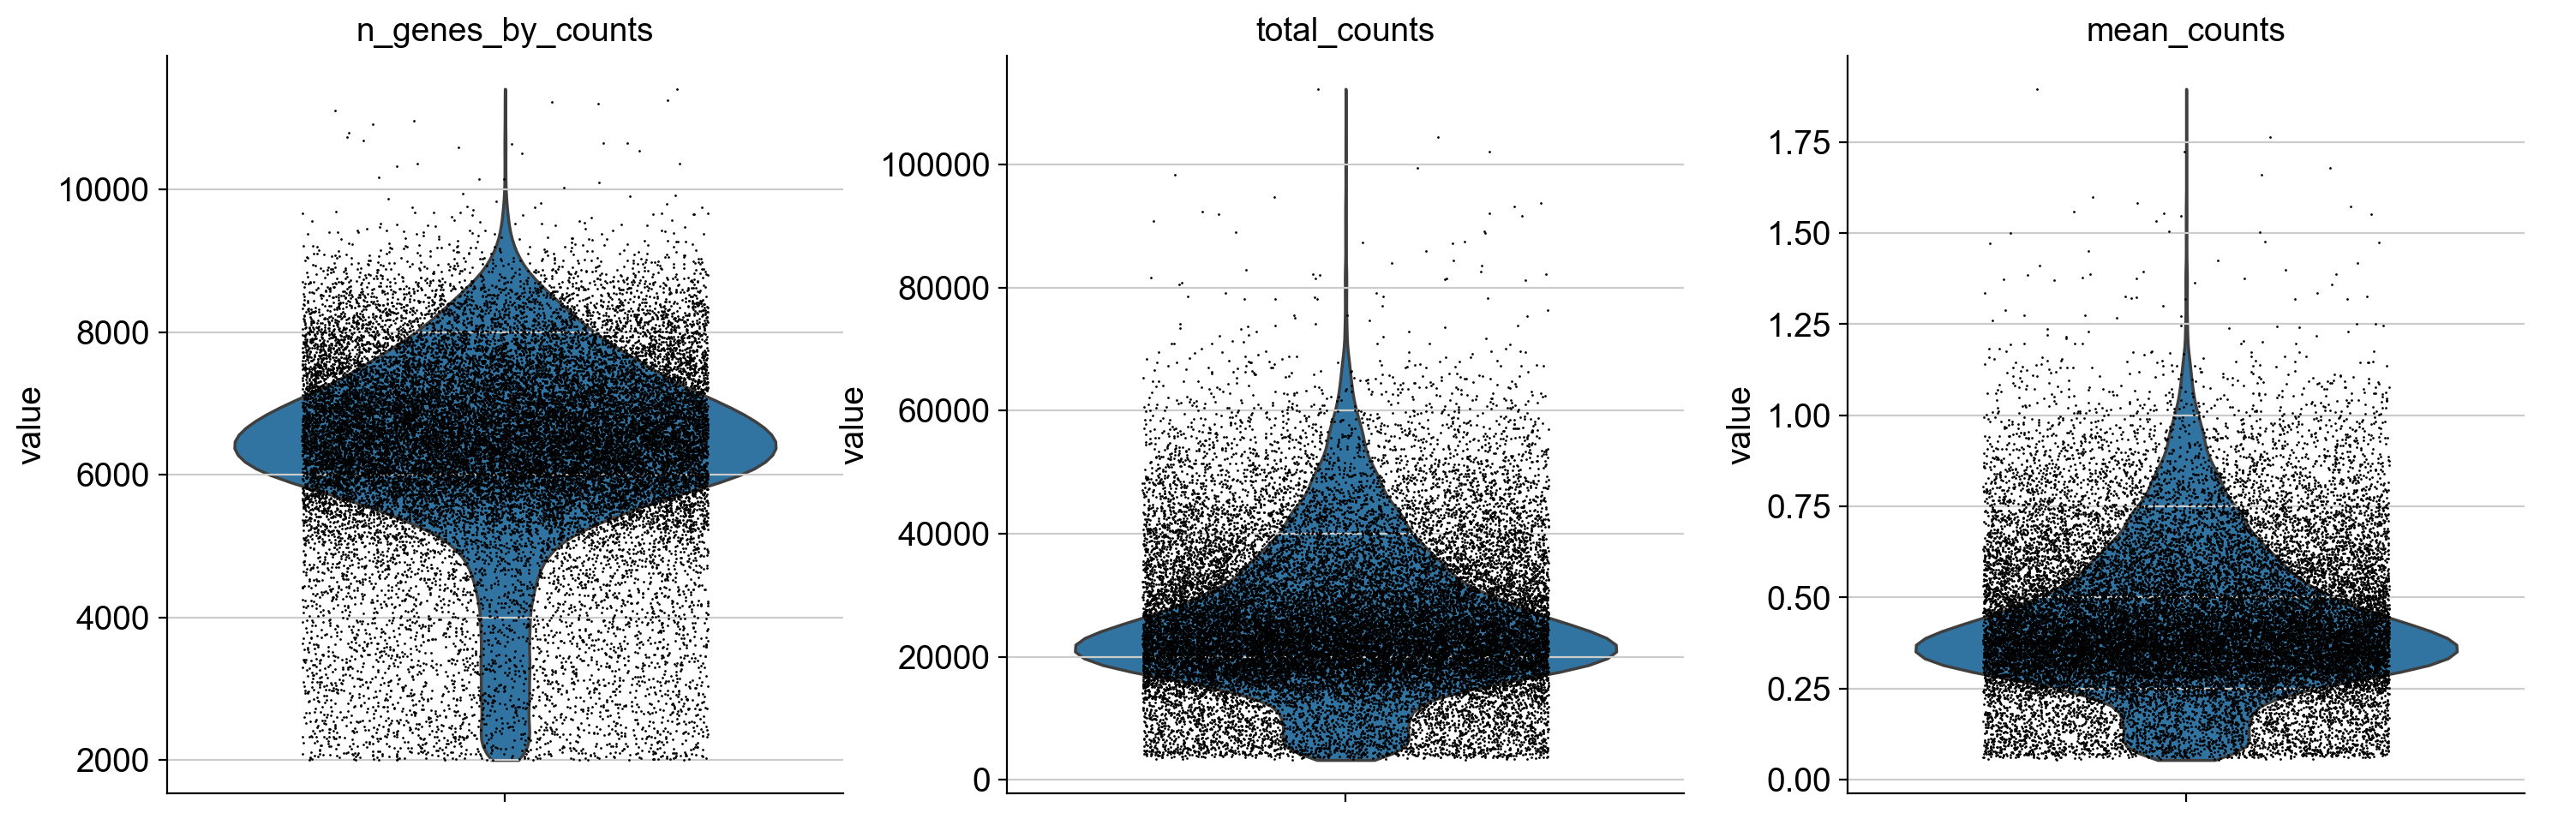

In [205]:
# Еще раз взглянем на график
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts', 'mean_counts'],
    jitter=0.3, multi_panel=True
)

In [206]:
adata = adata[adata.obs.n_genes_by_counts < 9_500, :] # удаляем гены которые обнаружены более чем в 9500 клетках
adata = adata[adata.obs.total_counts < 80_000, :] # насколько я понял тут мы удаляем клетки где найдено более 80 к мРНК

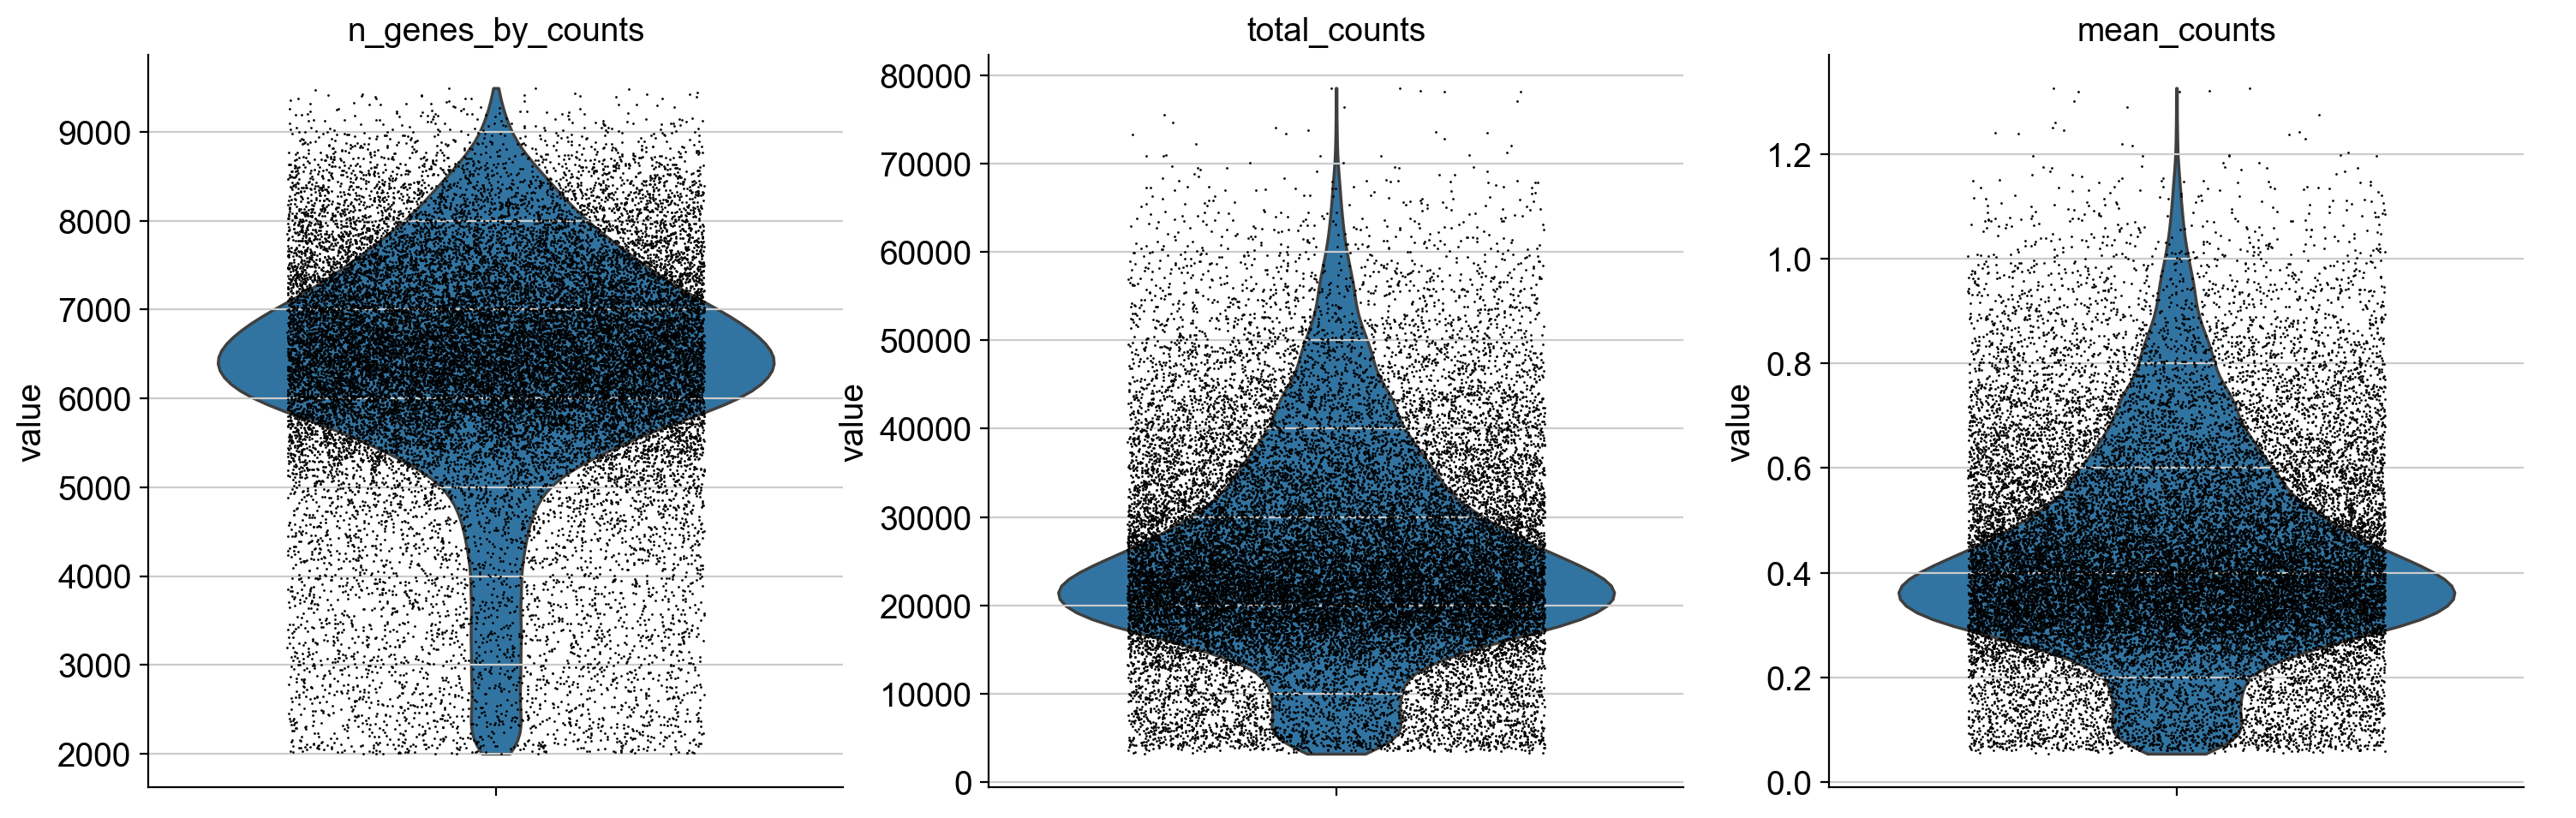

In [207]:
# Еще раз взглянем на график
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts', 'mean_counts'],
    jitter=0.3, multi_panel=True
)

In [208]:
adata

View of AnnData object with n_obs × n_vars = 27424 × 23028
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'mean_counts', 'n_genes_by_counts', 'total_counts', 'doublet_score', 'is_doublet', 'n_genes'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells_by_counts', 'mean_counts', 'pct_d

In [209]:
def plot_mean_var_plot(adata, log=False):
    arr = adata.X.toarray()
    mean_expression = arr.mean(axis=0)
    variance_expression = arr.var(axis=0)

    print(mean_expression.shape)

    plt.figure(figsize=(5, 5))
    if log:
        plt.scatter(np.log(mean_expression), np.log(variance_expression), alpha=0.5) # я тут залогарифмировал, иначе ппц выброс мешает
    else:
        plt.scatter((mean_expression), (variance_expression), alpha=0.5)  
    plt.title('Mean-var plot')
    plt.xlabel('Mean gene expression')
    plt.ylabel('Gene expression variance')

(23028,)


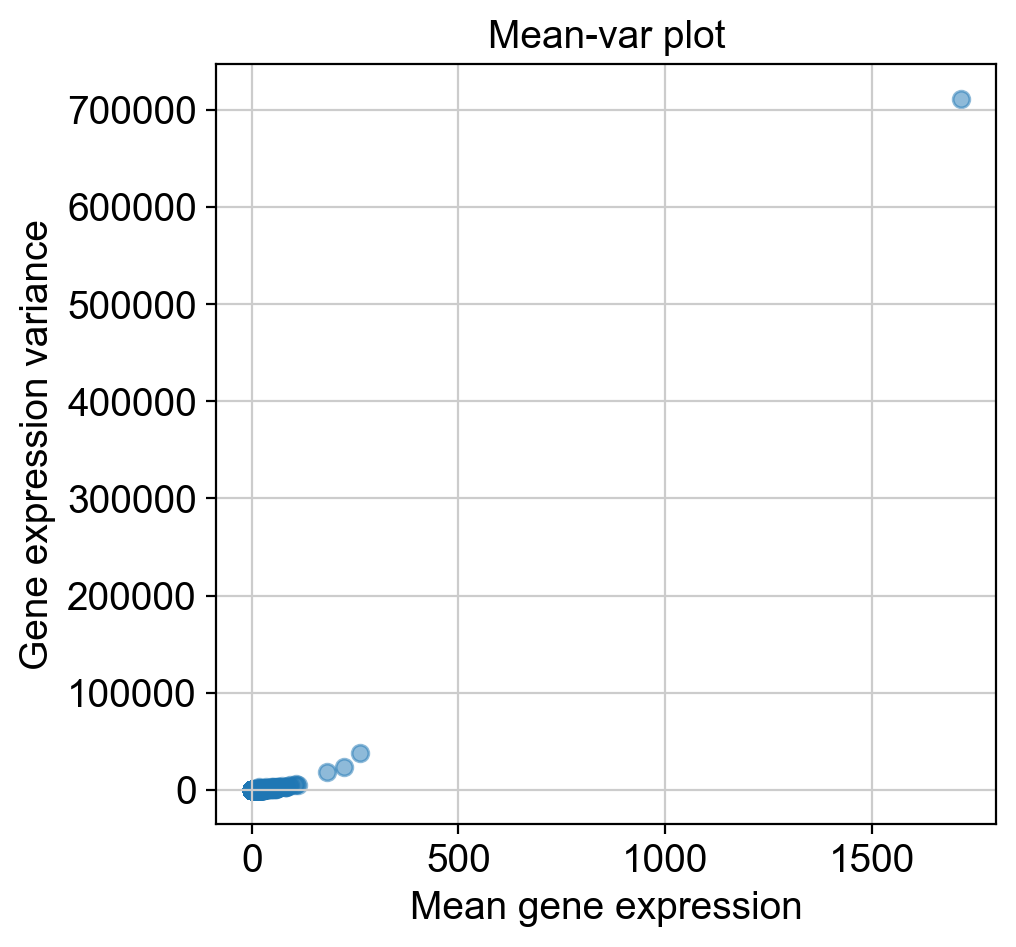

In [210]:
plot_mean_var_plot(adata)

(23028,)


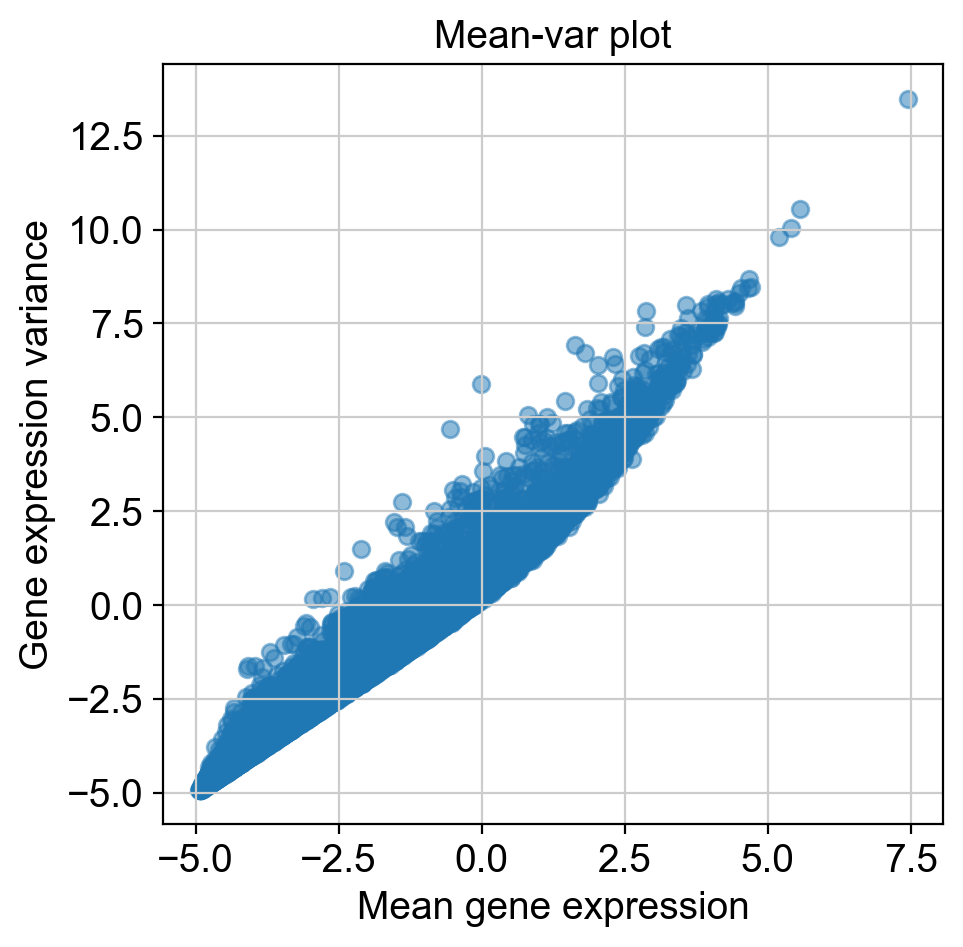

In [211]:
plot_mean_var_plot(adata, log=True)

РСА

In [212]:
# Считаем PCA
sc.tl.pca(adata)

computing PCA
    with n_comps=50


/Users/neuropromotion/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


    finished (0:00:54)


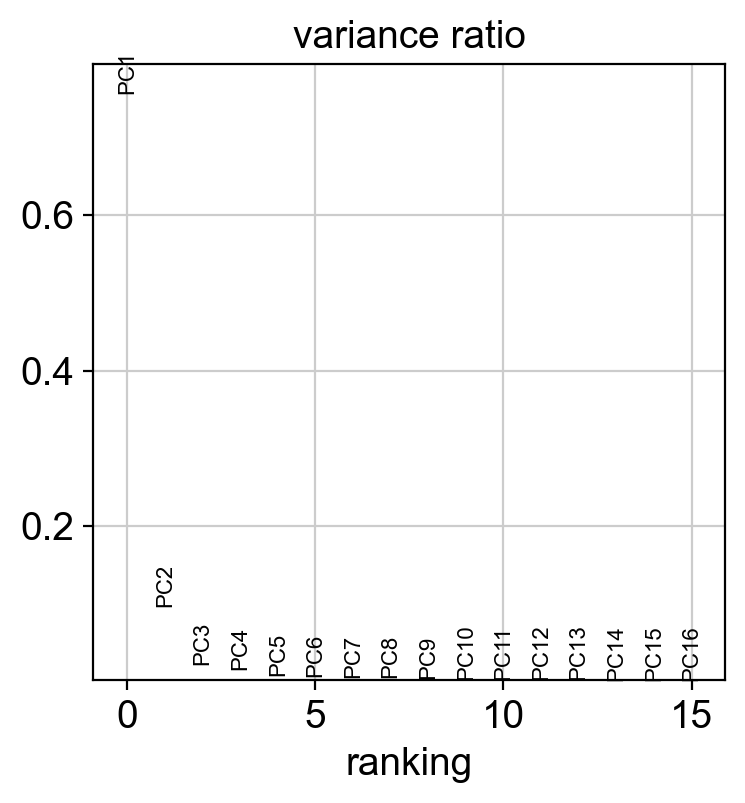

In [214]:
# Строим scree-plot. Сколько главных компонент логично использовать?
sc.pl.pca_variance_ratio(adata, n_pcs=15)

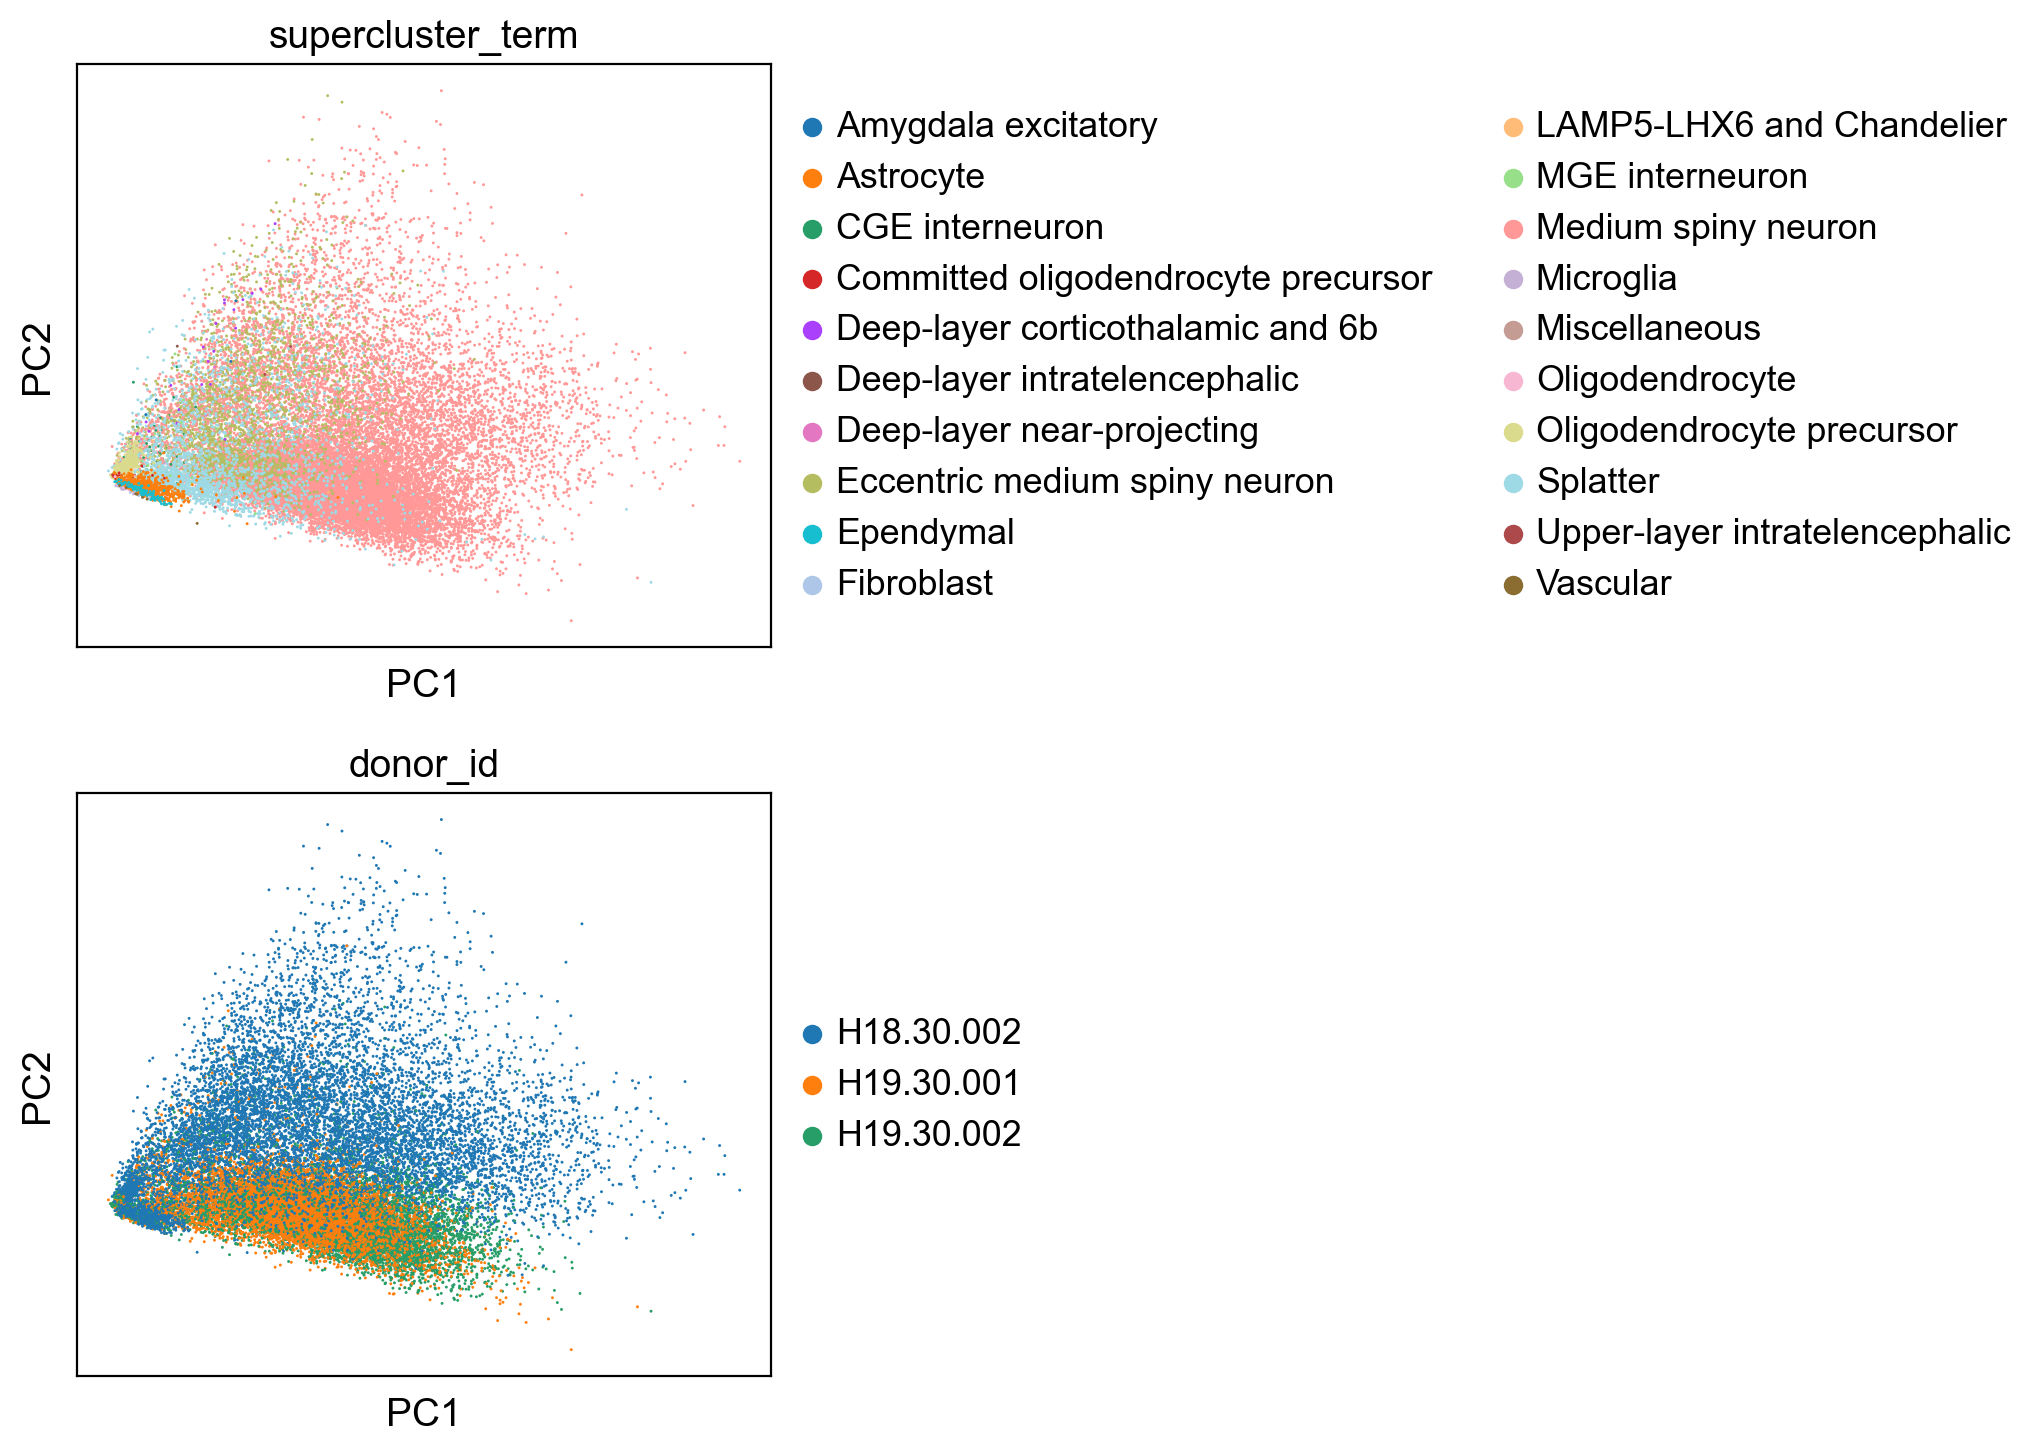

In [215]:
# Строим PCA
sc.pl.pca(adata, color=['supercluster_term', 'donor_id'], ncols=1)

In [219]:
def plot_gene_loadings_vs_mean_expression(adata, PC=1, log=False):
    mean_expression = np.array(adata.X.mean(axis=0)).flatten()
    pca_loadings = adata.varm['PCs'][:, PC-1]
    
    plt.figure(figsize=(5, 5))
    if log:
        plt.scatter(np.log(mean_expression), (pca_loadings), alpha=0.5)
    else:
        plt.scatter(mean_expression, pca_loadings, alpha=0.5)
    plt.title(f'PCA Loadings (PC{PC}) vs. Mean Gene Expression')
    plt.xlabel(f'Mean Gene Expression')
    plt.ylabel(f'PCA Loadings (PC{PC})')
    plt.grid(True)
    plt.show()

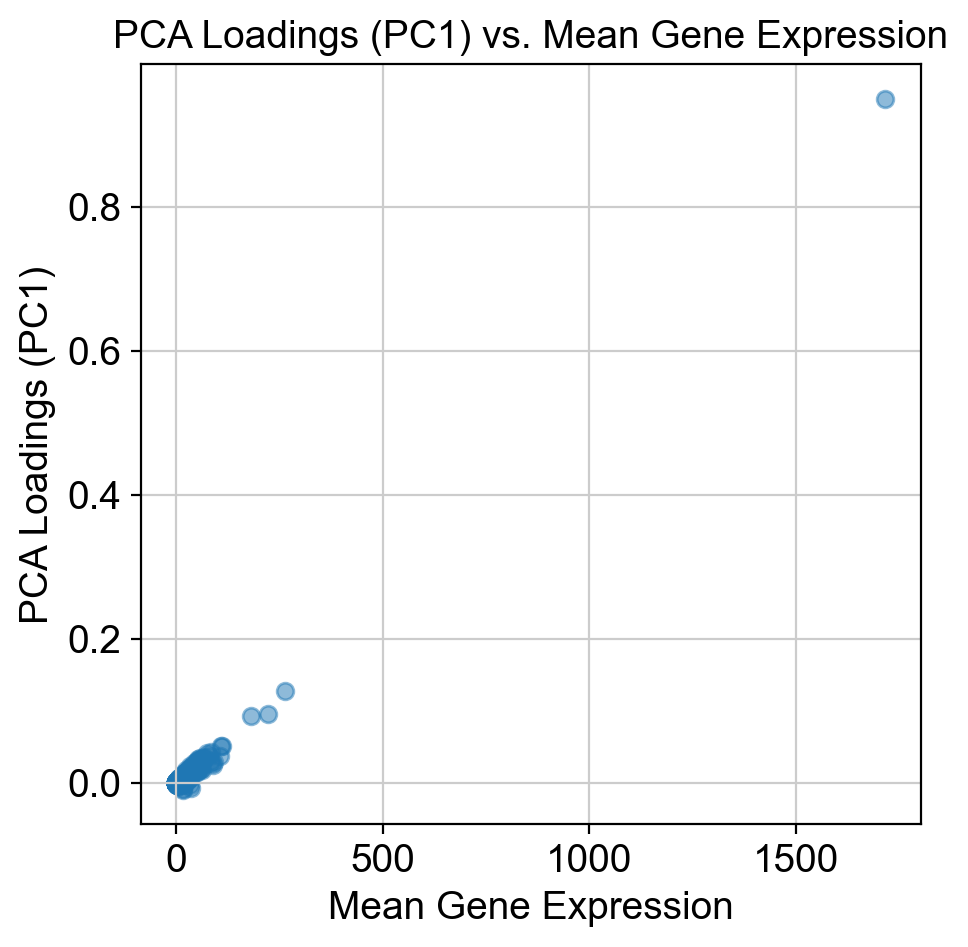

In [217]:
plot_gene_loadings_vs_mean_expression(adata, PC=1)

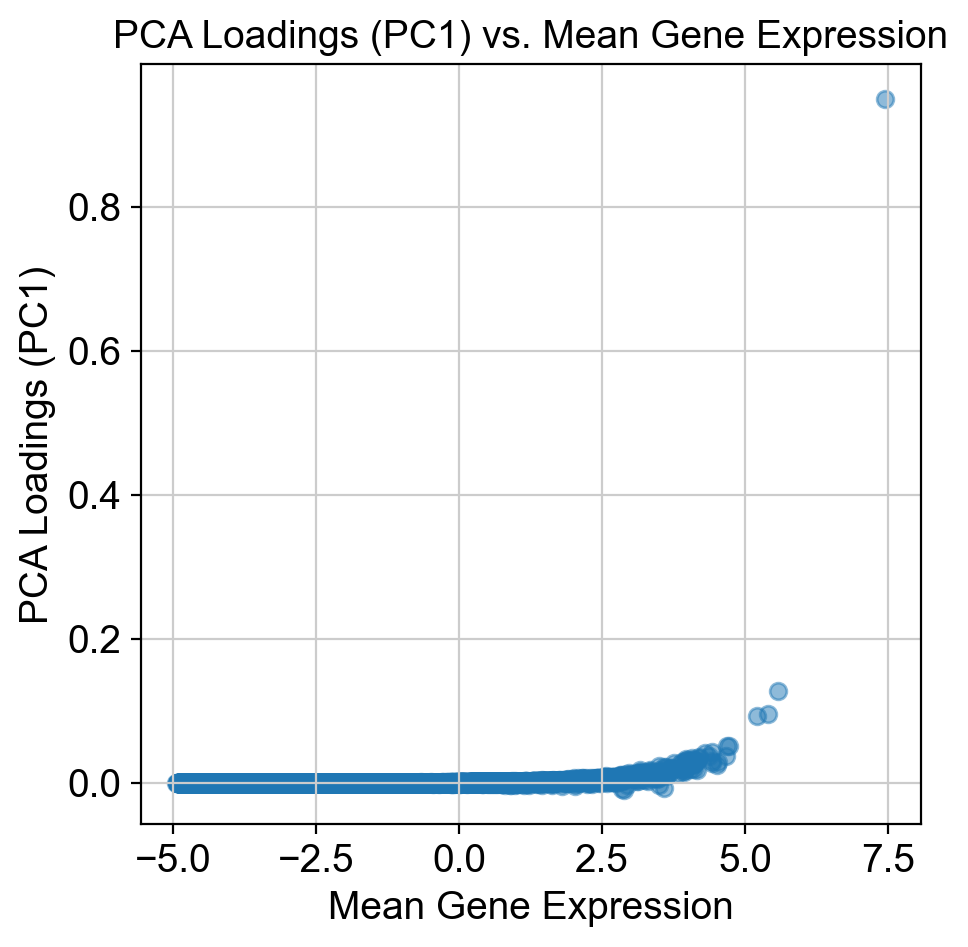

In [220]:
plot_gene_loadings_vs_mean_expression(adata, PC=1, log=True)

In [221]:
# Normalize the data to CPM & take the log
sc.pp.normalize_total(adata, target_sum=1e6)
# нормализуем к числу молекул на клетку. Здесь параметр target_sum устанавливается в 1 миллион (1e6), что означает, что общая сумма молекул в каждой клетке будет нормализована к значению 1 миллион
sc.pp.log1p(adata)
# Применение логарифмической функции ко всем значениям данных. Обычно используется для стабилизации дисперсии и снижения влияния выбросов

normalizing counts per cell
    finished (0:00:00)


(23028,)


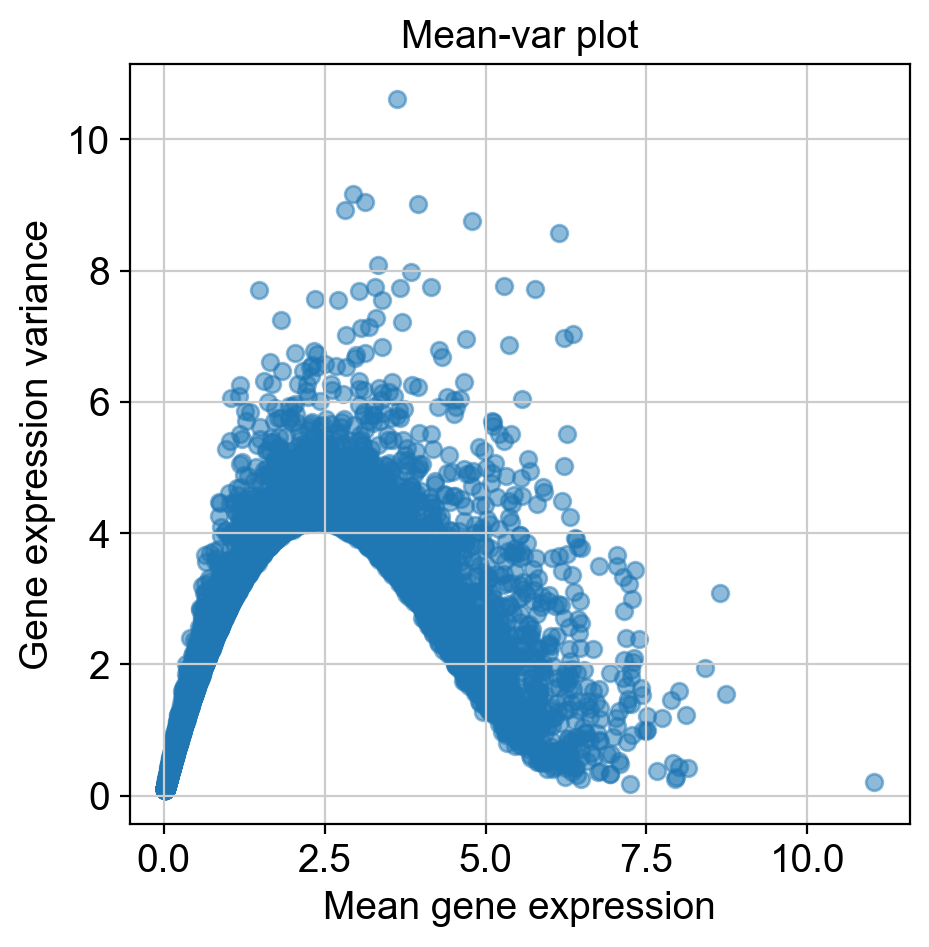

In [222]:
plot_mean_var_plot(adata)

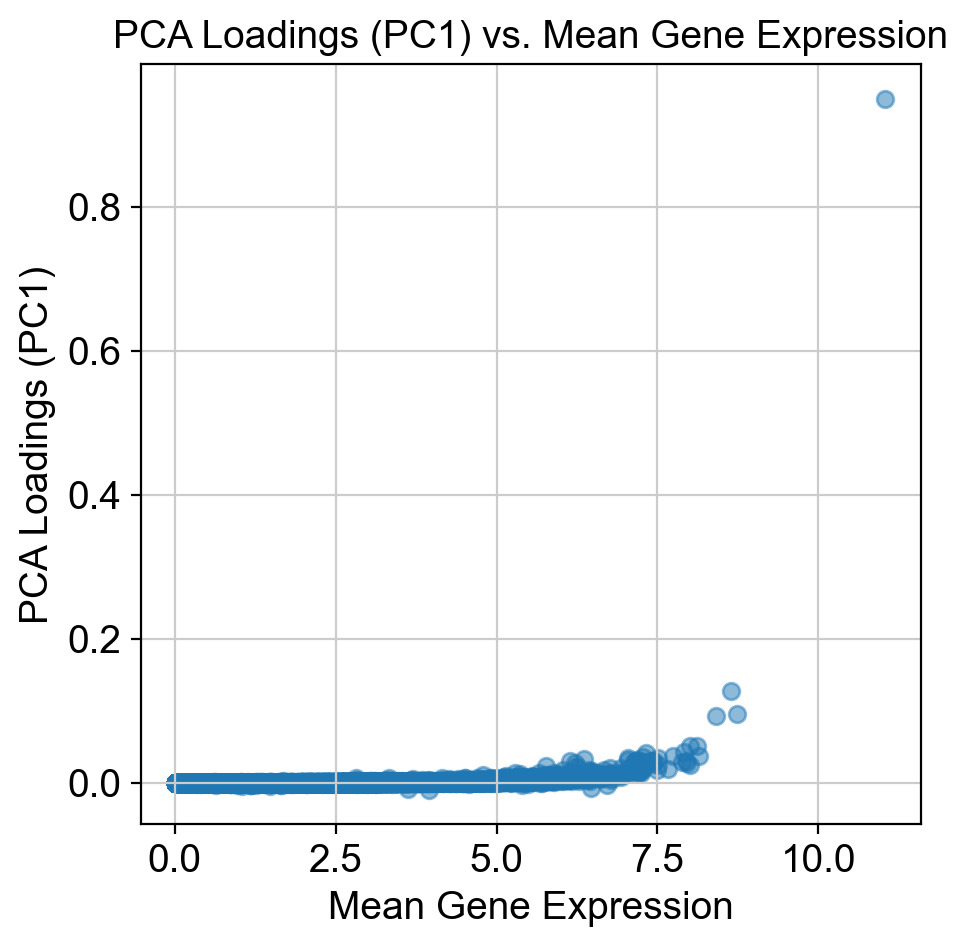

In [182]:
plot_gene_loadings_vs_mean_expression(adata, PC=1)

In [224]:
# Рассчитываем UMAP
sc.pp.neighbors(adata) # помним, для UMAP нужен kNN-graph!
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


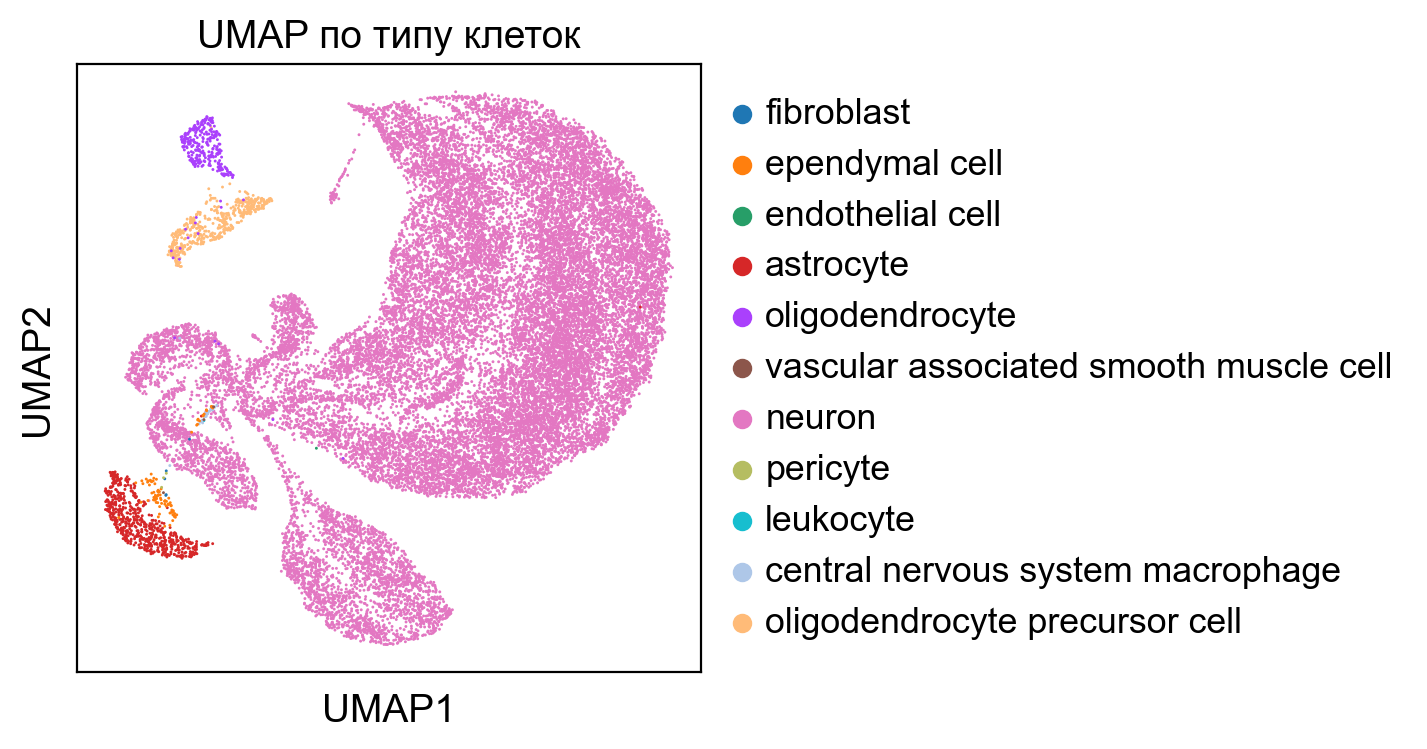

In [225]:
sc.pl.umap(adata, color='cell_type', title='UMAP по типу клеток')

  PIM2

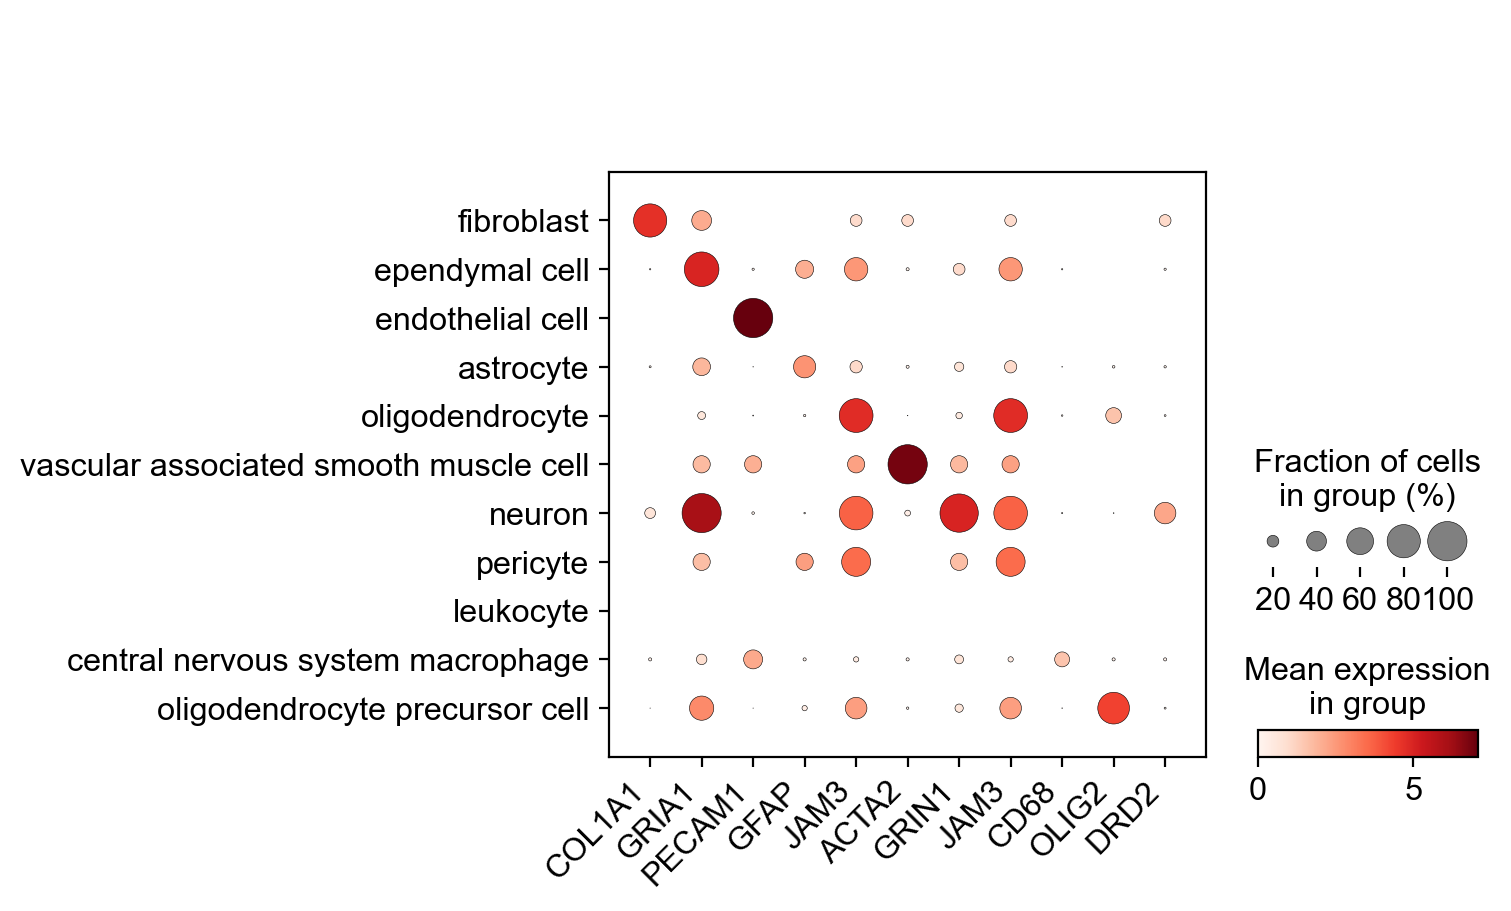

In [318]:
selected_genes = ['COL1A1','GRIA1', 'PECAM1', 'GFAP','JAM3', 'ACTA2', 'GRIN1', 'JAM3', 'CD68', 'OLIG2', 'DRD2']
dp = sc.pl.dotplot(adata, selected_genes, 
                   groupby="cell_type", gene_symbols='Gene', 
                   return_fig=True)

# Дополнительные настройки графиков (чтобы было красиво)
ax = dp.get_axes()['mainplot_ax']
ax.tick_params(axis='x', labelrotation=45)
for label in ax.get_xticklabels():
    label.set_ha('right')  # Horizontal alignment